PMF = probability mass function, dành cho discrete distributions

PDF = probability density function, dành cho continuous distributions

=> Hai định nghĩa trên được hiểu là xác suất xảy ra event với các params như p,n,.. tại giá trị x.

CDF = cumulative density function, là tổng xác suất từ giá trị đầu tiên đến giá trị x

SF = survival function, là tổng xác suất từ giá trị x đến giá trị cuối cùng, = 1-CDF

- Đối với discrete distributions thì 2 functions này tổng các PMF.
- Đối với continuous distributions thì 2 functions này là tích phân PDF

Ngược lại,
- PPF = percent point function, nhập CDF cho giá trị x
- ISF = inverse survival function, nhập SF cho giá trị x

DISCRETE DISTRIBUTIONS
- BERNOULLI DISTRIBUTION : phân phối xác suất xảy ra giữa 2 events. Nếu event thứ 1 là p thì event thứ 2 là 1-p
- BINOMIAL DISTRIBUTION : phân phối tổng của nhiều lần phân phối bernoulli. Phân phối xác suất xảy ra khi thực hiện m lần hypothesis A trên n lần thực hiện. Ví dụ: tung 1 đồng xu 100 lần. Mỗi lần tung xác suất mặt ngửa là 0.4, khi đó xác suất tung để ra mặt ngửa cao nhất là sau 40 lần tung
- GEOMETRIC DISTRIBUTION : phân phối xác suất của số lần để đạt được event đầu tiên. Xác xuất sẽ giảm dần. Ví dụ như xác suất với số lần tung để đạt được mặt sấp đầu tiên, với p(sấp) = 0.3 
- MULTINOMIAL DISTRIBUTION : phân phối tổng quát hóa của binomial 
- POISSON DISTRIBUTION : phân phối xác suất xảy ra event khi biết khoảng thời gian/không gian giữa 2 events xảy ra là hằng định. Ví dụ như các ngày, các tuần với nhau
CONTINUOUS DISTRIBUTIONS
- EXPONENTIAL DISTRIBUTION : phân phối xác suất xảy ra event khi biết khoảng thời gian giữa 2 events xảy ra là hằng định. Ví dụ như trong các giây liên tiếp,..Xác suất một người phải chờ đợi trong thời gian nào đó để một event xảy ra (hệ số phân phối luôn <=1)
- GAMMA DISTRIBUTION : 
* alpha <= 1. thì trở về dạng exponential distribution 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
%matplotlib inline

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/matplotlib/font_manager.py:229: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


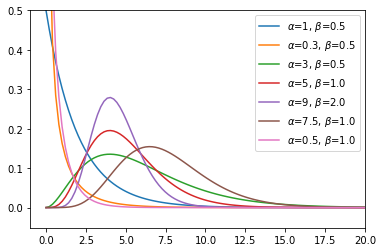

In [2]:
# plot giống trang wiki, 
arr = np.linspace(0,20,100)
params = zip([1,0.3,3,5,9,7.5,0.5], 1/np.array([2,2,2,1,0.5,1,1,1]))
for a, b in params:
    plt.plot(arr, st.gamma(a=a, scale=1/b).pdf(arr), label=r"$\alpha$={}, $\beta$={}".format(a,b))
plt.xlim(right=20)
plt.ylim(top=0.5)
plt.legend();

In [3]:
import bisect
import copy
import logging
import math
import numpy
import random

import scipy.stats
from scipy.special import erf, erfinv


def Odds(p):
    if p == 1:
        return float('inf')
    return p / (1 - p)
def Probability(o):
    return o / (o + 1)
def Probability2(yes, no):
    return float(yes) / (yes + no)
class Interpolator(object):
    def __init__(self, xs, ys):
        self.xs = xs
        self.ys = ys
    def Lookup(self, x):
        return self._Bisect(x, self.xs, self.ys)
    def Reverse(self, y):
        return self._Bisect(y, self.ys, self.xs)
    def _Bisect(self, x, xs, ys):
        if x <= xs[0]:
            return ys[0]
        if x >= xs[-1]:
            return ys[-1]
        i = bisect.bisect(xs, x)
        frac = 1.0 * (x - xs[i - 1]) / (xs[i] - xs[i - 1])
        y = ys[i - 1] + frac * 1.0 * (ys[i] - ys[i - 1])
        return y
class _DictWrapper(object):
    def __init__(self, values=None, name=''):
        self.name = name
        self.d = {}

        # flag whether the distribution is under a log transform
        self.log = False

        if values is None:
            return

        init_methods = [
            self.InitPmf,
            self.InitMapping,
            self.InitSequence,
            self.InitFailure,
            ]

        for method in init_methods:
            try:
                method(values)
                break
            except AttributeError:
                continue

        if len(self) > 0:
            self.Normalize()

    def InitSequence(self, values):
        for value in values:
            self.Set(value, 1)

    def InitMapping(self, values):
        for value, prob in values.iteritems():
            self.Set(value, prob)

    def InitPmf(self, values):
        for value, prob in values.Items():
            self.Set(value, prob)

    def InitFailure(self, values):
        raise ValueError('None of the initialization methods worked.')

    def __len__(self):
        return len(self.d)

    def __iter__(self):
        return iter(self.d)

    def iterkeys(self):
        return iter(self.d)

    def __contains__(self, value):
        return value in self.d

    def Copy(self, name=None):
        new = copy.copy(self)
        new.d = copy.copy(self.d)
        new.name = name if name is not None else self.name
        return new

    def Scale(self, factor):
        new = self.Copy()
        new.d.clear()

        for val, prob in self.Items():
            new.Set(val * factor, prob)
        return new

    def Log(self, m=None):
        if self.log:
            raise ValueError("Pmf/Hist already under a log transform")
        self.log = True

        if m is None:
            m = self.MaxLike()

        for x, p in self.d.iteritems():
            if p:
                self.Set(x, math.log(p / m))
            else:
                self.Remove(x)

    def Exp(self, m=None):
        if not self.log:
            raise ValueError("Pmf/Hist not under a log transform")
        self.log = False

        if m is None:
            m = self.MaxLike()

        for x, p in self.d.iteritems():
            self.Set(x, math.exp(p - m))

    def GetDict(self):
        """Gets the dictionary."""
        return self.d

    def SetDict(self, d):
        """Sets the dictionary."""
        self.d = d

    def Values(self):
        return self.d.keys()

    def Items(self):
        """Gets an unsorted sequence of (value, freq/prob) pairs."""
        return self.d.items()

    def Render(self):
        return zip(*sorted(self.Items()))

    def Print(self):
        """Prints the values and freqs/probs in ascending order."""
        for val, prob in sorted(self.d.iteritems()):
            print (val, prob)

    def Set(self, x, y=0):
        self.d[x] = y

    def Incr(self, x, term=1):
        self.d[x] = self.d.get(x, 0) + term

    def Mult(self, x, factor):
        """Scales the freq/prob associated with the value x.

        Args:
            x: number value
            factor: how much to multiply by
        """
        self.d[x] = self.d.get(x, 0) * factor

    def Remove(self, x):
        """Removes a value.

        Throws an exception if the value is not there.

        Args:
            x: value to remove
        """
        del self.d[x]

    def Total(self):
        """Returns the total of the frequencies/probabilities in the map."""
        total = 0
        for x in self.d.values():
            total = total + x
        #total = sum(self.d.itervalues())
        return total

    def MaxLike(self):
        """Returns the largest frequency/probability in the map."""
        return max(self.d.itervalues())


class Hist(_DictWrapper):
    def Freq(self, x):
        return self.d.get(x, 0)

    def Freqs(self, xs):
        """Gets frequencies for a sequence of values."""
        return [self.Freq(x) for x in xs]

    def IsSubset(self, other):
        """Checks whether the values in this histogram are a subset of
        the values in the given histogram."""
        for val, freq in self.Items():
            if freq > other.Freq(val):
                return False
        return True

    def Subtract(self, other):
        """Subtracts the values in the given histogram from this histogram."""
        for val, freq in other.Items():
            self.Incr(val, -freq)


class Pmf(_DictWrapper):
    """Represents a probability mass function.
    
    Values can be any hashable type; probabilities are floating-point.
    Pmfs are not necessarily normalized.
    """

    def Prob(self, x, default=0):
        """Gets the probability associated with the value x.

        Args:
            x: number value
            default: value to return if the key is not there

        Returns:
            float probability
        """
        return self.d.get(x, default)

    def Probs(self, xs):
        """Gets probabilities for a sequence of values."""
        return [self.Prob(x) for x in xs]

    def MakeCdf(self, name=None):
        """Makes a Cdf."""
        return MakeCdfFromPmf(self, name=name)

    def ProbGreater(self, x):
        t = [prob for (val, prob) in self.d.iteritems() if val > x]
        return sum(t)

    def ProbLess(self, x):
        t = [prob for (val, prob) in self.d.iteritems() if val < x]
        return sum(t)

    def Normalize(self, fraction=1.0):
        """Normalizes this PMF so the sum of all probs is fraction.

        Args:
            fraction: what the total should be after normalization

        Returns: the total probability before normalizing
        """
        if self.log:
            raise ValueError("Pmf is under a log transform")

        total = self.Total()
        if total == 0.0:
            raise ValueError('total probability is zero.')
            logging.warning('Normalize: total probability is zero.')
            return total

        factor = float(fraction) / total
        for x in self.d:
            self.d[x] *= factor

        return total

    def Random(self):
        """Chooses a random element from this PMF.

        Returns:
            float value from the Pmf
        """
        if len(self.d) == 0:
            raise ValueError('Pmf contains no values.')

        target = random.random()
        total = 0.0
        for x, p in self.d.iteritems():
            total += p
            if total >= target:
                return x

        # we shouldn't get here
        assert False

    def Mean(self):
        """Computes the mean of a PMF.

        Returns:
            float mean
        """
        mu = 0.0
        for x, p in self.d.iteritems():
            mu += p * x
        return mu

    def Var(self, mu=None):
        """Computes the variance of a PMF.

        Args:
            mu: the point around which the variance is computed;
                if omitted, computes the mean

        Returns:
            float variance
        """
        if mu is None:
            mu = self.Mean()

        var = 0.0
        for x, p in self.d.iteritems():
            var += p * (x - mu) ** 2
        return var

    def MaximumLikelihood(self):
        """Returns the value with the highest probability.

        Returns: float probability
        """
        prob, val = max((prob, val) for val, prob in self.Items())
        return val

    def CredibleInterval(self, percentage=90):
        """Computes the central credible interval.

        If percentage=90, computes the 90% CI.

        Args:
            percentage: float between 0 and 100

        Returns:
            sequence of two floats, low and high
        """
        cdf = self.MakeCdf()
        return cdf.CredibleInterval(percentage)

    def __add__(self, other):
        """Computes the Pmf of the sum of values drawn from self and other.

        other: another Pmf

        returns: new Pmf
        """
        try:
            return self.AddPmf(other)
        except AttributeError:
            return self.AddConstant(other)

    def AddPmf(self, other):
        """Computes the Pmf of the sum of values drawn from self and other.

        other: another Pmf

        returns: new Pmf
        """
        pmf = Pmf()
        for v1, p1 in self.Items():
            for v2, p2 in other.Items():
                pmf.Incr(v1 + v2, p1 * p2)
        return pmf

    def AddConstant(self, other):
        """Computes the Pmf of the sum a constant and  values from self.

        other: a number

        returns: new Pmf
        """
        pmf = Pmf()
        for v1, p1 in self.Items():
            pmf.Set(v1 + other, p1)
        return pmf

    def __sub__(self, other):
        """Computes the Pmf of the diff of values drawn from self and other.

        other: another Pmf

        returns: new Pmf
        """
        pmf = Pmf()
        for v1, p1 in self.Items():
            for v2, p2 in other.Items():
                pmf.Incr(v1 - v2, p1 * p2)
        return pmf

    def Max(self, k):
        """Computes the CDF of the maximum of k selections from this dist.

        k: int

        returns: new Cdf
        """
        cdf = self.MakeCdf()
        cdf.ps = [p ** k for p in cdf.ps]
        return cdf


class Joint(Pmf):
    """Represents a joint distribution.

    The values are sequences (usually tuples)
    """

    def Marginal(self, i, name=''):
        """Gets the marginal distribution of the indicated variable.

        i: index of the variable we want

        Returns: Pmf
        """
        pmf = Pmf(name=name)
        for vs, prob in self.Items():
            pmf.Incr(vs[i], prob)
        return pmf

    def Conditional(self, i, j, val, name=''):
        """Gets the conditional distribution of the indicated variable.

        Distribution of vs[i], conditioned on vs[j] = val.

        i: index of the variable we want
        j: which variable is conditioned on
        val: the value the jth variable has to have

        Returns: Pmf
        """
        pmf = Pmf(name=name)
        for vs, prob in self.Items():
            if vs[j] != val: continue
            pmf.Incr(vs[i], prob)

        pmf.Normalize()
        return pmf

    def MaxLikeInterval(self, percentage=90):
        """Returns the maximum-likelihood credible interval.

        If percentage=90, computes a 90% CI containing the values
        with the highest likelihoods.

        percentage: float between 0 and 100

        Returns: list of values from the suite
        """
        interval = []
        total = 0

        t = [(prob, val) for val, prob in self.Items()]
        t.sort(reverse=True)

        for prob, val in t:
            interval.append(val)
            total += prob
            if total >= percentage / 100.0:
                break

        return interval


def MakeJoint(pmf1, pmf2):
    """Joint distribution of values from pmf1 and pmf2.

    Args:
        pmf1: Pmf object
        pmf2: Pmf object

    Returns:
        Joint pmf of value pairs
    """
    joint = Joint()
    for v1, p1 in pmf1.Items():
        for v2, p2 in pmf2.Items():
            joint.Set((v1, v2), p1 * p2)
    return joint


def MakeHistFromList(t, name=''):
    """Makes a histogram from an unsorted sequence of values.

    Args:
        t: sequence of numbers
        name: string name for this histogram

    Returns:
        Hist object
    """
    hist = Hist(name=name)
    [hist.Incr(x) for x in t]
    return hist


def MakeHistFromDict(d, name=''):
    """Makes a histogram from a map from values to frequencies.

    Args:
        d: dictionary that maps values to frequencies
        name: string name for this histogram

    Returns:
        Hist object
    """
    return Hist(d, name)


def MakePmfFromList(t, name=''):
    """Makes a PMF from an unsorted sequence of values.

    Args:
        t: sequence of numbers
        name: string name for this PMF

    Returns:
        Pmf object
    """
    hist = MakeHistFromList(t)
    d = hist.GetDict()
    pmf = Pmf(d, name)
    pmf.Normalize()
    return pmf


def MakePmfFromDict(d, name=''):
    """Makes a PMF from a map from values to probabilities.

    Args:
        d: dictionary that maps values to probabilities
        name: string name for this PMF

    Returns:
        Pmf object
    """
    pmf = Pmf(d, name)
    pmf.Normalize()
    return pmf


def MakePmfFromItems(t, name=''):
    """Makes a PMF from a sequence of value-probability pairs

    Args:
        t: sequence of value-probability pairs
        name: string name for this PMF

    Returns:
        Pmf object
    """
    pmf = Pmf(dict(t), name)
    pmf.Normalize()
    return pmf


def MakePmfFromHist(hist, name=None):
    """Makes a normalized PMF from a Hist object.

    Args:
        hist: Hist object
        name: string name

    Returns:
        Pmf object
    """
    if name is None:
        name = hist.name

    # make a copy of the dictionary
    d = dict(hist.GetDict())
    pmf = Pmf(d, name)
    pmf.Normalize()
    return pmf


def MakePmfFromCdf(cdf, name=None):
    """Makes a normalized Pmf from a Cdf object.

    Args:
        cdf: Cdf object
        name: string name for the new Pmf

    Returns:
        Pmf object
    """
    if name is None:
        name = cdf.name

    pmf = Pmf(name=name)

    prev = 0.0
    for val, prob in cdf.Items():
        pmf.Incr(val, prob - prev)
        prev = prob

    return pmf


def MakeMixture(metapmf, name='mix'):
    """Make a mixture distribution.

    Args:
      metapmf: Pmf that maps from Pmfs to probs.
      name: string name for the new Pmf.

    Returns: Pmf object.
    """
    mix = Pmf(name=name)
    for pmf, p1 in metapmf.Items():
        for x, p2 in pmf.Items():
            mix.Incr(x, p1 * p2)
    return mix


def MakeUniformPmf(low, high, n):
    """Make a uniform Pmf.

    low: lowest value (inclusive)
    high: highest value (inclusize)
    n: number of values
    """
    pmf = Pmf()
    for x in numpy.linspace(low, high, n):
        pmf.Set(x, 1)
    pmf.Normalize()
    return pmf


class Cdf(object):
    """Represents a cumulative distribution function.

    Attributes:
        xs: sequence of values
        ps: sequence of probabilities
        name: string used as a graph label.
    """

    def __init__(self, xs=None, ps=None, name=''):
        self.xs = [] if xs is None else xs
        self.ps = [] if ps is None else ps
        self.name = name

    def Copy(self, name=None):
        """Returns a copy of this Cdf.

        Args:
            name: string name for the new Cdf
        """
        if name is None:
            name = self.name
        return Cdf(list(self.xs), list(self.ps), name)

    def MakePmf(self, name=None):
        """Makes a Pmf."""
        return MakePmfFromCdf(self, name=name)

    def Values(self):
        """Returns a sorted list of values.
        """
        return self.xs

    def Items(self):
        """Returns a sorted sequence of (value, probability) pairs.

        Note: in Python3, returns an iterator.
        """
        return zip(self.xs, self.ps)

    def Append(self, x, p):
        """Add an (x, p) pair to the end of this CDF.

        Note: this us normally used to build a CDF from scratch, not
        to modify existing CDFs.  It is up to the caller to make sure
        that the result is a legal CDF.
        """
        self.xs.append(x)
        self.ps.append(p)

    def Shift(self, term):
        """Adds a term to the xs.

        term: how much to add
        """
        new = self.Copy()
        new.xs = [x + term for x in self.xs]
        return new

    def Scale(self, factor):
        """Multiplies the xs by a factor.

        factor: what to multiply by
        """
        new = self.Copy()
        new.xs = [x * factor for x in self.xs]
        return new

    def Prob(self, x):
        """Returns CDF(x), the probability that corresponds to value x.

        Args:
            x: number

        Returns:
            float probability
        """
        if x < self.xs[0]: return 0.0
        index = bisect.bisect(self.xs, x)
        p = self.ps[index - 1]
        return p

    def Value(self, p):
        """Returns InverseCDF(p), the value that corresponds to probability p.

        Args:
            p: number in the range [0, 1]

        Returns:
            number value
        """
        if p < 0 or p > 1:
            raise ValueError('Probability p must be in range [0, 1]')

        if p == 0: return self.xs[0]
        if p == 1: return self.xs[-1]
        index = bisect.bisect(self.ps, p)
        if p == self.ps[index - 1]:
            return self.xs[index - 1]
        else:
            return self.xs[index]

    def Percentile(self, p):
        """Returns the value that corresponds to percentile p.

        Args:
            p: number in the range [0, 100]

        Returns:
            number value
        """
        return self.Value(p / 100.0)

    def Random(self):
        """Chooses a random value from this distribution."""
        return self.Value(random.random())

    def Sample(self, n):
        """Generates a random sample from this distribution.
        
        Args:
            n: int length of the sample
        """
        return [self.Random() for i in range(n)]

    def Mean(self):
        """Computes the mean of a CDF.

        Returns:
            float mean
        """
        old_p = 0
        total = 0.0
        for x, new_p in zip(self.xs, self.ps):
            p = new_p - old_p
            total += p * x
            old_p = new_p
        return total

    def CredibleInterval(self, percentage=90):
        """Computes the central credible interval.

        If percentage=90, computes the 90% CI.

        Args:
            percentage: float between 0 and 100

        Returns:
            sequence of two floats, low and high
        """
        prob = (1 - percentage / 100.0) / 2
        interval = self.Value(prob), self.Value(1 - prob)
        return interval

    def _Round(self, multiplier=1000.0):
        """
        An entry is added to the cdf only if the percentile differs
        from the previous value in a significant digit, where the number
        of significant digits is determined by multiplier.  The
        default is 1000, which keeps log10(1000) = 3 significant digits.
        """
        # TODO(write this method)
        raise UnimplementedMethodException()

    def Render(self):
        """Generates a sequence of points suitable for plotting.

        An empirical CDF is a step function; linear interpolation
        can be misleading.

        Returns:
            tuple of (xs, ps)
        """
        xs = [self.xs[0]]
        ps = [0.0]
        for i, p in enumerate(self.ps):
            xs.append(self.xs[i])
            ps.append(p)

            try:
                xs.append(self.xs[i + 1])
                ps.append(p)
            except IndexError:
                pass
        return xs, ps

    def Max(self, k):
        """Computes the CDF of the maximum of k selections from this dist.

        k: int

        returns: new Cdf
        """
        cdf = self.Copy()
        cdf.ps = [p ** k for p in cdf.ps]
        return cdf


def MakeCdfFromItems(items, name=''):
    """Makes a cdf from an unsorted sequence of (value, frequency) pairs.

    Args:
        items: unsorted sequence of (value, frequency) pairs
        name: string name for this CDF

    Returns:
        cdf: list of (value, fraction) pairs
    """
    runsum = 0
    xs = []
    cs = []

    for value, count in sorted(items):
        runsum += count
        xs.append(value)
        cs.append(runsum)

    total = float(runsum)
    ps = [c / total for c in cs]

    cdf = Cdf(xs, ps, name)
    return cdf


def MakeCdfFromDict(d, name=''):
    """Makes a CDF from a dictionary that maps values to frequencies.

    Args:
       d: dictionary that maps values to frequencies.
       name: string name for the data.

    Returns:
        Cdf object
    """
    return MakeCdfFromItems(d.iteritems(), name)


def MakeCdfFromHist(hist, name=''):
    """Makes a CDF from a Hist object.

    Args:
       hist: Pmf.Hist object
       name: string name for the data.

    Returns:
        Cdf object
    """
    return MakeCdfFromItems(hist.Items(), name)


def MakeCdfFromPmf(pmf, name=None):
    """Makes a CDF from a Pmf object.

    Args:
       pmf: Pmf.Pmf object
       name: string name for the data.

    Returns:
        Cdf object
    """
    if name == None:
        name = pmf.name
    return MakeCdfFromItems(pmf.Items(), name)


def MakeCdfFromList(seq, name=''):
    """Creates a CDF from an unsorted sequence.

    Args:
        seq: unsorted sequence of sortable values
        name: string name for the cdf

    Returns:
       Cdf object
    """
    hist = MakeHistFromList(seq)
    return MakeCdfFromHist(hist, name)


class UnimplementedMethodException(Exception):
    """Exception if someone calls a method that should be overridden."""


class Suite(Pmf):
    """Represents a suite of hypotheses and their probabilities."""

    def Update(self, data):
        """Updates each hypothesis based on the data.

        data: any representation of the data

        returns: the normalizing constant
        """
        for hypo in self.Values():
            like = self.Likelihood(data, hypo)
            self.Mult(hypo, like)
        return self.Normalize()

    def LogUpdate(self, data):
        """Updates a suite of hypotheses based on new data.

        Modifies the suite directly; if you want to keep the original, make
        a copy.

        Note: unlike Update, LogUpdate does not normalize.

        Args:
            data: any representation of the data
        """
        for hypo in self.Values():
            like = self.LogLikelihood(data, hypo)
            self.Incr(hypo, like)

    def UpdateSet(self, dataset):
        """Updates each hypothesis based on the dataset.

        This is more efficient than calling Update repeatedly because
        it waits until the end to Normalize.

        Modifies the suite directly; if you want to keep the original, make
        a copy.

        dataset: a sequence of data

        returns: the normalizing constant
        """
        for data in dataset:
            for hypo in self.Values():
                like = self.Likelihood(data, hypo)
                self.Mult(hypo, like)
        return self.Normalize()

    def LogUpdateSet(self, dataset):
        """Updates each hypothesis based on the dataset.

        Modifies the suite directly; if you want to keep the original, make
        a copy.

        dataset: a sequence of data

        returns: None
        """
        for data in dataset:
            self.LogUpdate(data)

    def Likelihood(self, data, hypo):
        """Computes the likelihood of the data under the hypothesis.

        hypo: some representation of the hypothesis
        data: some representation of the data
        """
        raise UnimplementedMethodException()

    def LogLikelihood(self, data, hypo):
        """Computes the log likelihood of the data under the hypothesis.

        hypo: some representation of the hypothesis
        data: some representation of the data
        """
        raise UnimplementedMethodException()

    def Print(self):
        """Prints the hypotheses and their probabilities."""
        for hypo, prob in sorted(self.Items()):
            print (hypo, prob)

    def MakeOdds(self):
        """Transforms from probabilities to odds.

        Values with prob=0 are removed.
        """
        for hypo, prob in self.Items():
            if prob:
                self.Set(hypo, Odds(prob))
            else:
                self.Remove(hypo)

    def MakeProbs(self):
        """Transforms from odds to probabilities."""
        for hypo, odds in self.Items():
            self.Set(hypo, Probability(odds))


def MakeSuiteFromList(t, name=''):
    """Makes a suite from an unsorted sequence of values.

    Args:
        t: sequence of numbers
        name: string name for this suite

    Returns:
        Suite object
    """
    hist = MakeHistFromList(t)
    d = hist.GetDict()
    return MakeSuiteFromDict(d)


def MakeSuiteFromHist(hist, name=None):
    """Makes a normalized suite from a Hist object.

    Args:
        hist: Hist object
        name: string name

    Returns:
        Suite object
    """
    if name is None:
        name = hist.name

    # make a copy of the dictionary
    d = dict(hist.GetDict())
    return MakeSuiteFromDict(d, name)


def MakeSuiteFromDict(d, name=''):
    """Makes a suite from a map from values to probabilities.

    Args:
        d: dictionary that maps values to probabilities
        name: string name for this suite

    Returns:
        Suite object
    """
    suite = Suite(name=name)
    suite.SetDict(d)
    suite.Normalize()
    return suite


def MakeSuiteFromCdf(cdf, name=None):
    """Makes a normalized Suite from a Cdf object.

    Args:
        cdf: Cdf object
        name: string name for the new Suite

    Returns:
        Suite object
    """
    if name is None:
        name = cdf.name

    suite = Suite(name=name)

    prev = 0.0
    for val, prob in cdf.Items():
        suite.Incr(val, prob - prev)
        prev = prob

    return suite


class Pdf(object):
    """Represents a probability density function (PDF)."""

    def Density(self, x):
        """Evaluates this Pdf at x.

        Returns: float probability density
        """
        raise UnimplementedMethodException()

    def MakePmf(self, xs, name=''):
        """Makes a discrete version of this Pdf, evaluated at xs.

        xs: equally-spaced sequence of values

        Returns: new Pmf
        """
        pmf = Pmf(name=name)
        for x in xs:
            pmf.Set(x, self.Density(x))
        pmf.Normalize()
        return pmf


class GaussianPdf(Pdf):
    """Represents the PDF of a Gaussian distribution."""

    def __init__(self, mu, sigma):
        """Constructs a Gaussian Pdf with given mu and sigma.

        mu: mean
        sigma: standard deviation
        """
        self.mu = mu
        self.sigma = sigma

    def Density(self, x):
        """Evaluates this Pdf at x.

        Returns: float probability density
        """
        return EvalGaussianPdf(x, self.mu, self.sigma)


class EstimatedPdf(Pdf):
    """Represents a PDF estimated by KDE."""

    def __init__(self, sample):
        """Estimates the density function based on a sample.

        sample: sequence of data
        """
        self.kde = scipy.stats.gaussian_kde(sample)

    def Density(self, x):
        """Evaluates this Pdf at x.

        Returns: float probability density
        """
        return self.kde.evaluate(x)

    def MakePmf(self, xs, name=''):
        ps = self.kde.evaluate(xs)
        pmf = MakePmfFromItems(zip(xs, ps), name=name)
        return pmf


def Percentile(pmf, percentage):
    """Computes a percentile of a given Pmf.

    percentage: float 0-100
    """
    p = percentage / 100.0
    total = 0
    for val, prob in pmf.Items():
        total += prob
        if total >= p:
            return val


def CredibleInterval(pmf, percentage=90):
    """Computes a credible interval for a given distribution.

    If percentage=90, computes the 90% CI.

    Args:
        pmf: Pmf object representing a posterior distribution
        percentage: float between 0 and 100

    Returns:
        sequence of two floats, low and high
    """
    cdf = pmf.MakeCdf()
    prob = (1 - percentage / 100.0) / 2
    interval = cdf.Value(prob), cdf.Value(1 - prob)
    return interval


def PmfProbLess(pmf1, pmf2):
    """Probability that a value from pmf1 is less than a value from pmf2.

    Args:
        pmf1: Pmf object
        pmf2: Pmf object

    Returns:
        float probability
    """
    total = 0.0
    for v1, p1 in pmf1.Items():
        for v2, p2 in pmf2.Items():
            if v1 < v2:
                total += p1 * p2
    return total


def PmfProbGreater(pmf1, pmf2):
    """Probability that a value from pmf1 is less than a value from pmf2.

    Args:
        pmf1: Pmf object
        pmf2: Pmf object

    Returns:
        float probability
    """
    total = 0.0
    for v1, p1 in pmf1.Items():
        for v2, p2 in pmf2.Items():
            if v1 > v2:
                total += p1 * p2
    return total


def PmfProbEqual(pmf1, pmf2):
    """Probability that a value from pmf1 equals a value from pmf2.

    Args:
        pmf1: Pmf object
        pmf2: Pmf object

    Returns:
        float probability
    """
    total = 0.0
    for v1, p1 in pmf1.Items():
        for v2, p2 in pmf2.Items():
            if v1 == v2:
                total += p1 * p2
    return total


def RandomSum(dists):
    """Chooses a random value from each dist and returns the sum.

    dists: sequence of Pmf or Cdf objects

    returns: numerical sum
    """
    total = sum(dist.Random() for dist in dists)
    return total


def SampleSum(dists, n):
    """Draws a sample of sums from a list of distributions.

    dists: sequence of Pmf or Cdf objects
    n: sample size

    returns: new Pmf of sums
    """
    pmf = MakePmfFromList(RandomSum(dists) for i in xrange(n))
    return pmf


def EvalGaussianPdf(x, mu, sigma):
    """Computes the unnormalized PDF of the normal distribution.

    x: value
    mu: mean
    sigma: standard deviation
    
    returns: float probability density
    """
    return scipy.stats.norm.pdf(x, mu, sigma)


def MakeGaussianPmf(mu, sigma, num_sigmas, n=201):
    """Makes a PMF discrete approx to a Gaussian distribution.
    
    mu: float mean
    sigma: float standard deviation
    num_sigmas: how many sigmas to extend in each direction
    n: number of values in the Pmf

    returns: normalized Pmf
    """
    pmf = Pmf()
    low = mu - num_sigmas * sigma
    high = mu + num_sigmas * sigma

    for x in numpy.linspace(low, high, n):
        p = EvalGaussianPdf(x, mu, sigma)
        pmf.Set(x, p)
    pmf.Normalize()
    return pmf


def EvalBinomialPmf(k, n, p):
    """Evaluates the binomial pmf.

    Returns the probabily of k successes in n trials with probability p.
    """
    return scipy.stats.binom.pmf(k, n, p)
    

def EvalPoissonPmf(k, lam):
    """Computes the Poisson PMF.

    k: number of events
    lam: parameter lambda in events per unit time

    returns: float probability
    """
    # don't use the scipy function.  for lam=0 it returns NaN;
    # should be 0.0
    return scipy.stats.poisson.pmf(k, lam)

    #return lam ** k * math.exp(-lam) / math.factorial(k)


def MakePoissonPmf(lam, high, step=1):
    """Makes a PMF discrete approx to a Poisson distribution.

    lam: parameter lambda in events per unit time
    high: upper bound of the Pmf

    returns: normalized Pmf
    """
    pmf = Pmf()
    for k in xrange(0, high + 1, step):
        p = EvalPoissonPmf(k, lam)
        pmf.Set(k, p)
    pmf.Normalize()
    return pmf


def EvalExponentialPdf(x, lam):
    """Computes the exponential PDF.

    x: value
    lam: parameter lambda in events per unit time

    returns: float probability density
    """
    return lam * math.exp(-lam * x)


def EvalExponentialCdf(x, lam):
    """Evaluates CDF of the exponential distribution with parameter lam."""
    return 1 - math.exp(-lam * x)


def MakeExponentialPmf(lam, high, n=200):
    """Makes a PMF discrete approx to an exponential distribution.

    lam: parameter lambda in events per unit time
    high: upper bound
    n: number of values in the Pmf

    returns: normalized Pmf
    """
    pmf = Pmf()
    for x in numpy.linspace(0, high, n):
        p = EvalExponentialPdf(x, lam)
        pmf.Set(x, p)
    pmf.Normalize()
    return pmf


def StandardGaussianCdf(x, root2=math.sqrt(2)):
    """Evaluates the CDF of the standard Gaussian distribution.
    
    See http://en.wikipedia.org/wiki/Normal_distribution
    #Cumulative_distribution_function

    Args:
        x: float
                
    Returns:
        float
    """
    return (erf(x / root2) + 1) / 2


def GaussianCdf(x, mu=0, sigma=1):
    """Evaluates the CDF of the gaussian distribution.
    
    Args:
        x: float

        mu: mean parameter
        
        sigma: standard deviation parameter
                
    Returns:
        float
    """
    return StandardGaussianCdf(float(x - mu) / sigma)


def GaussianCdfInverse(p, mu=0, sigma=1):
    """Evaluates the inverse CDF of the gaussian distribution.

    See http://en.wikipedia.org/wiki/Normal_distribution#Quantile_function  

    Args:
        p: float

        mu: mean parameter
        
        sigma: standard deviation parameter
                
    Returns:
        float
    """
    x = root2 * erfinv(2 * p - 1)
    return mu + x * sigma


class Beta(object):
    """Represents a Beta distribution.

    See http://en.wikipedia.org/wiki/Beta_distribution
    """
    def __init__(self, alpha=1, beta=1, name=''):
        """Initializes a Beta distribution."""
        self.alpha = alpha
        self.beta = beta
        self.name = name

    def Update(self, data):
        """Updates a Beta distribution.

        data: pair of int (heads, tails)
        """
        heads, tails = data
        self.alpha += heads
        self.beta += tails

    def Mean(self):
        """Computes the mean of this distribution."""
        return float(self.alpha) / (self.alpha + self.beta)

    def Random(self):
        """Generates a random variate from this distribution."""
        return random.betavariate(self.alpha, self.beta)

    def EvalPdf(self, x):
        """Evaluates the PDF at x."""
        return x ** (self.alpha - 1) * (1 - x) ** (self.beta - 1)

    def MakePmf(self, steps=101, name=''):
        """Returns a Pmf of this distribution.

        Note: Normally, we just evaluate the PDF at a sequence
        of points and treat the probability density as a probability
        mass.

        But if alpha or beta is less than one, we have to be
        more careful because the PDF goes to infinity at x=0
        and x=1.  In that case we evaluate the CDF and compute
        differences.
        """
        if self.alpha < 1 or self.beta < 1:
            cdf = self.MakeCdf()
            pmf = cdf.MakePmf()
            return pmf

        xs = [i / (steps - 1.0) for i in xrange(steps)]
        probs = [self.EvalPdf(x) for x in xs]
        pmf = MakePmfFromDict(dict(zip(xs, probs)), name)
        return pmf

    def MakeCdf(self, steps=101):
        """Returns the CDF of this distribution."""
        xs = [i / (steps - 1.0) for i in xrange(steps)]
        ps = [scipy.special.betainc(self.alpha, self.beta, x) for x in xs]
        cdf = Cdf(xs, ps)
        return cdf


class Dirichlet(object):
    """Represents a Dirichlet distribution.

    See http://en.wikipedia.org/wiki/Dirichlet_distribution
    """

    def __init__(self, n, conc=1, name=''):
        """Initializes a Dirichlet distribution.

        n: number of dimensions
        conc: concentration parameter (smaller yields more concentration)
        name: string name
        """
        if n < 2:
            raise ValueError('A Dirichlet distribution with '
                             'n<2 makes no sense')

        self.n = n
        self.params = numpy.ones(n, dtype=numpy.float) * conc
        self.name = name

    def Update(self, data):
        """Updates a Dirichlet distribution.

        data: sequence of observations, in order corresponding to params
        """
        m = len(data)
        self.params[:m] += data

    def Random(self):
        """Generates a random variate from this distribution.

        Returns: normalized vector of fractions
        """
        p = numpy.random.gamma(self.params)
        return p / p.sum()

    def Likelihood(self, data):
        """Computes the likelihood of the data.

        Selects a random vector of probabilities from this distribution.

        Returns: float probability
        """
        m = len(data)
        if self.n < m:
            return 0

        x = data
        p = self.Random()
        q = p[:m] ** x
        return q.prod()

    def LogLikelihood(self, data):
        """Computes the log likelihood of the data.

        Selects a random vector of probabilities from this distribution.

        Returns: float log probability
        """
        m = len(data)
        if self.n < m:
            return float('-inf')

        x = self.Random()
        y = numpy.log(x[:m]) * data
        return y.sum()

    def MarginalBeta(self, i):
        """Computes the marginal distribution of the ith element.

        See http://en.wikipedia.org/wiki/Dirichlet_distribution
        #Marginal_distributions

        i: int

        Returns: Beta object
        """
        alpha0 = self.params.sum()
        alpha = self.params[i]
        return Beta(alpha, alpha0 - alpha)

    def PredictivePmf(self, xs, name=''):
        """Makes a predictive distribution.

        xs: values to go into the Pmf

        Returns: Pmf that maps from x to the mean prevalence of x
        """
        alpha0 = self.params.sum()
        ps = self.params / alpha0
        return MakePmfFromItems(zip(xs, ps), name=name)


def BinomialCoef(n, k):
    """Compute the binomial coefficient "n choose k".

    n: number of trials
    k: number of successes

    Returns: float
    """
    return scipy.misc.comb(n, k)


def LogBinomialCoef(n, k):
    """Computes the log of the binomial coefficient.

    http://math.stackexchange.com/questions/64716/
    approximating-the-logarithm-of-the-binomial-coefficient

    n: number of trials
    k: number of successes

    Returns: float
    """
    return n * log(n) - k * log(k) - (n - k) * log(n - k)



So in practice 1, we went through some first understanding of Bayesian Inference. The more case falls into this hypothesis, the bigger our belief is, and our probability of belief is expressed by Bayes Theorem. In this practice 2, we will go on some other problems to get a deep insight. 

Example 1: DICE PROBLEM

Suppose I have a box of dice that contains a 4-sided die, a 6-sided die, an
8-sided die, a 12-sided die, and a 20-sided die. If you have ever played
Dungeons & Dragons, you know what I am talking about.
Suppose I select a die from the box at random, roll it, and get a 6. What is
the probability that I rolled each die?
Let me suggest a three-step strategy for approaching a problem like this.
1. Choose a representation for the hypotheses.
2. Choose a representation for the data.
3. Write the likelihood function.

It's similar to previous problem. First, hypothesis is "if number on dice falls into which from 5 types of dice", data is a range of natural numbers from 1 to 20 respective to point(s) on dice. 

What about likelihood ?
- 4-sided die : obviously it's impossible 
- n-sided die (n >= 6) : 1/n 

The bigger n, the smaller prob is. 

So what will happen if there are more than a time rolling. For instance, [7,7,8,9,10] (1)

4-sided and 6-sided and 8-sided dice is eliminated so its likelihood is 0 
I can say that from (1) i have belief that 12-sided die will have highest prob. But we have to compute it by code. 

In [4]:
class DICE(Pmf):                    
    def __init__(self, hypos):       
        Pmf.__init__(self)
        for hypo in hypos:
            self.Set(hypo, 1)
        self.Normalize()
    def Update(self, data):
        for hypo in self.Values():
            like = self.Likelihood(data, hypo)
            self.Mult(hypo, like)
        self.Normalize()
    def Likelihood(self, data, hypo):
        if hypo < data:
            return 0
        else:
            return 1.0/hypo
def main():
    hypos = [4,6,8,12,20]
    pmf = DICE(hypos)
    dice = [7,7,8,9,10]
    for data in dice:
        pmf.Update(data)
    for hypo, prob in pmf.Items():
        print (hypo, prob)
if __name__ == '__main__':
    main()

4 0.0
6 0.0
8 0.0
12 0.9278503562945368
20 0.07214964370546323


Trong cả Practice 1 và một phần Practice 2, chúng ta đã đi qua một số ví dụ trong việc ứng dựng Bayes Theorem. Mặt khác, với Bayesian Method, tiếng Việt là suy diễn trong thống kê, hay học máy,..rõ ràng là chưa được thể hiện rõ ràng. Luôn nhớ một điều rằng, suy diễn thống kê phụ thuộc vào niềm tin của người làm (chủ quan) nhưng lại dựa trên những cái khách quan trong đời sống. Với ví dụ này: có một đoàn tàu, có N toa tàu đánh số từ 1,2,3,..,N. Một người nhìn thấy 1 toa tàu số 60. Hỏi N là bao nhiêu ?

Xác định cụ thể N là bao nhiêu với từng đấy dữ liệu là một điều không thế. Ta chỉ có thể biết được N >= 60. Người ta gọi đây là Prior, là cái đã biết trước. Nếu chỉ dựa vào điều này, rõ ràng là niềm tin của user chưa đủ rõ, nên mọi giả định đều có thể xảy ra. Ta đưa ra những hypos từ 60 đến 500 chẳng hạn. Bài toán trở về quen thuộc

Trên thực tế thì prior luôn khá rõ để user có thể nhận định patterns từ dữ liệu.

Giả sử 1 người thấy 3 toa 30, 60, 90 thì số trường hợp sẽ được giảm bớt. N >= 90. Kết quả có thể chọn lấy N có xác suất cao nhất, hoặc lấy trung bình.

Suy diễn ở đâu? Nó nằm ở con số 500. Trên thực tế thì không có 1 đoàn tàu nào lại có tận 500 toa cả, cũng như đoàn tàu 1 toa lại càng vô lý. Do đó, dựa vào thực tế, người ta sẽ đưa ra một giới hạn nào đó hợp lí hơn, như việc lấy số liệu từ 1 công ty đường sắt chẳng hạn. 

Power Law : được hiểu qua một ví dụ như sau : có một loạt công ty đường sắt. Nếu có 1000 công ty loại bé với 10 khoang, thì sẽ có 100 công ty loại vừa 100 khoang, 10 công ty loại khá 1000 khoang và 1 công ty với 10000 khoang. Công ty càng lớn, thì số lượng càng nhỏ và số khoang ại càng lớn. 

147.92306281714832


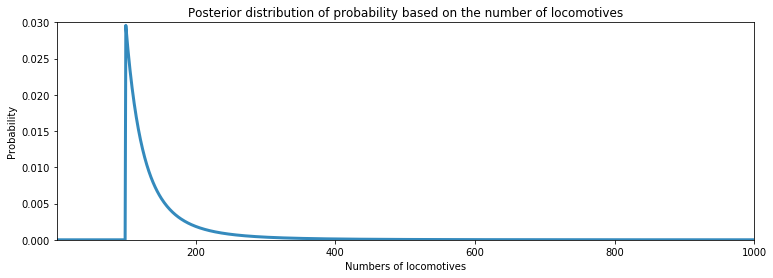

In [19]:
class Locomotive(Pmf):                    
    def __init__(self, hypos):       
        Pmf.__init__(self)
        for hypo in hypos:
            self.Set(hypo, 1)
        self.Normalize()
    def Update(self, data):
        for hypo in self.Values():
            like = self.Likelihood(data, hypo)
            self.Mult(hypo, like)
        self.Normalize()
    def Likelihood(self, data, hypo):
        if hypo < data:
            return 0
        else:
            return 1.0/hypo
        
from matplotlib import pyplot as plt
import scipy.stats as stats
from IPython.core.pylabtools import figsize

def main():
    hypos = [i for i in range(1,1001)]
    pmf = Locomotive(hypos)
    locomotives = [30,60,90,100]
    for data in locomotives:
        pmf.Update(data)
    total = 0
    for hypo, prob in pmf.Items():
        total = total + hypo*prob
    print(total)
    probs = []
    for hypo, prob in pmf.Items():
        probs.append(prob) 
    figsize(12.5, 4)
    plt.plot(hypos, probs, color="#348ABD", lw=3)
    #plt.fill_between(p, 2*p/(1+p), alpha=.5, facecolor=["#A60628"])
    plt.xlim(1, 1000)
    plt.ylim(0, .03)
    plt.xlabel("Numbers of locomotives")
    plt.ylabel("Probability")
    plt.title("Posterior distribution of probability based on the number of locomotives");
if __name__ == '__main__':
    main()

In [18]:
class Locomotive2(Pmf):                    
    def __init__(self, hypos, alpha = 1.0):       
        Pmf.__init__(self)
        for hypo in hypos:
            self.Set(hypo, hypo**(-alpha))
        self.Normalize()
    def Update(self, data):
        for hypo in self.Values():
            like = self.Likelihood(data, hypo)
            self.Mult(hypo, like)
        self.Normalize()
    def Likelihood(self, data, hypo):
        if hypo < data:
            return 0
        else:
            return 1.0/hypo
from matplotlib import pyplot as plt
import scipy.stats as stats
from IPython.core.pylabtools import figsize
def Mean(items):
    total = 0
    for hypo, prob in items:
        total = total + hypo*prob 
    return total 
def main():
    hypos1 = [i for i in range(1,1001)]
    hypos2 = [i for i in range(1,501)]
    hypos3 = [i for i in range(1,701)]
    hypos4 = [i for i in range(1,201)]
    pmf1 = Locomotive2(hypos1)
    pmf2 = Locomotive2(hypos2)
    pmf3 = Locomotive2(hypos3)
    pmf4 = Locomotive2(hypos4)
    locomotives = [30,60,90,100]
    for data in locomotives:
        pmf1.Update(data)
        pmf2.Update(data)
        pmf3.Update(data)
        pmf4.Update(data)
    print(len(hypos1), Mean(pmf1.Items()))
    print(len(hypos2), Mean(pmf2.Items()))
    print(len(hypos3), Mean(pmf3.Items()))
    print(len(hypos4), Mean(pmf4.Items()))
if __name__ == '__main__':
    main()

1000 132.55359871020354
500 131.83462473659557
700 132.34478308436417
200 123.97572795259751


Như vậy, số locomotives khoảng 132 là hợp lý. Ngoài mean ra, bạn có thể tính ra median theo tùy trường hợp. 

KHOẢNG TIN CẬY (CREDIBLE INTERVALS) là khoảng mà trong khoảng đó tồn tại một giá trị có xác suất bằng 90%. Một cách đơn giản tính ra khoảng tin cậy là những giá trị có xác suất >5% và <95%. Cùng thử tính ra khoảng tin cậy trong ví dụ locomotive: 

In [21]:
class Locomotive3(Pmf):                    
    def __init__(self, hypos, alpha = 1.0):       
        Pmf.__init__(self)
        for hypo in hypos:
            self.Set(hypo, hypo**(-alpha))
        self.Normalize()
    def Update(self, data):
        for hypo in self.Values():
            like = self.Likelihood(data, hypo)
            self.Mult(hypo, like)
        self.Normalize()
    def Likelihood(self, data, hypo):
        if hypo < data:
            return 0
        else:
            return 1.0/hypo
def Mean(items):
    total = 0
    for hypo, prob in items:
        total = total + hypo*prob 
    return total 
def Percentile(items , percentage):
    p = percentage / 100.0
    total = 0
    for val, prob in items:
        total += prob
        if total >= p:
            return val
def main():
    hypos = [i for i in range(1,1001)]
    pmf = Locomotive3(hypos)
    locomotives = [30,60,90,100]
    for data in locomotives:
        pmf.Update(data)
    print(Mean(pmf.Items()))
    interval = Percentile(pmf.Items(), 5), Percentile(pmf.Items(), 95)
    print(interval)
if __name__ == '__main__':
    main()

132.55359871020354
(101, 210)


Như vậy (101,210) là khoảng mà số lượng locomotives có xác suất rơi vào là "đáng tin cậy nhất". 

In [50]:
#Như đã nói ở trên, CDF là tổng xác suất từ đầu đến một giá trị thứ x. CDF tương tự như PMF, và có thể convert từ dạng này sang dạng kia. 
def findCDF(items, mark):
    cdf_value = 0
    count = 0
    for hypo, prob in items:
        count = count + 1
        cdf_value = cdf_value + prob
        if (count == mark):
            return cdf_value
            break
def convert(items, mark):
    return findCDF(items, mark)-findCDF(items, mark-1)
def findPDF(items, mark):
    for hypo, prob in items:
        if hypo == mark :
            return prob 
            break

In [57]:
def main():
    hypos = [i for i in range(1,1001)]
    pmf = Locomotive3(hypos)
    locomotives = [30,60,90,100]
    for data in locomotives:
        pmf.Update(data)
    print(Mean(pmf.Items()))
    interval = Percentile(pmf.Items(), 5), Percentile(pmf.Items(), 95)
    print(interval)
    print(findCDF(pmf.Items(), 800))
    print(convert(pmf.Items(), 500))
    print(findPDF(pmf.Items(), 500))
if __name__ == '__main__':
    main()

132.55359871020354
(101, 210)
0.9998590967426563
1.2548197149353513e-05
1.2548197149358663e-05


GERMAN TANK PROBLEM : Trong suốt thế chiến II,  the Economic Warfare Division of the American Embassy in London đã dùng phân tích thống kê để ước tính lượng sản xuất xe tăng và những thiết bị khác. Bài toán là, các thiết bị được đánh số liên tiếp từ 1 đến N. Nếu được chọn ngẫu nhiên một lượng mặt hàng và có được các số ghi trên đó, xác định xem N = ? Bài toán không khác gì so với locomotive ở trên. 

Giả sử chọn được ra 4 số 19, 40, 42, 60. 

In [104]:
class GERMAN(Pmf):                    
    def __init__(self, hypos, alpha = 1.0):       
        Pmf.__init__(self)
        for hypo in hypos:
            self.Set(hypo, hypo**(-alpha))
        self.Normalize()
    def Update(self, data):
        for hypo in self.Values():
            like = self.Likelihood(data, hypo)
            self.Mult(hypo, like)
        self.Normalize()
    def Likelihood(self, data, hypo):
        if hypo < data:
            return 0
        else:
            return 1.0/hypo
from matplotlib import pyplot as plt
import scipy.stats as stats
from IPython.core.pylabtools import figsize
def Mean(items):
    total = 0
    for hypo, prob in items:
        total = total + hypo*prob 
    return total 
def main():
    hypos1 = [i for i in range(1,1001)]
    hypos2 = [i for i in range(1,501)]
    hypos3 = [i for i in range(1,701)]
    hypos4 = [i for i in range(1,201)]
    hypos5 = [i for i in range(1,101)]
    pmf1 = GERMAN(hypos1)
    pmf2 = GERMAN(hypos2)
    pmf3 = GERMAN(hypos3)
    pmf4 = GERMAN(hypos4)
    pmf5 = GERMAN(hypos5)
    chosen_item = [19,40,42,60]
    for data in chosen_item:
        pmf1.Update(data)
        pmf2.Update(data)
        pmf3.Update(data)
        pmf4.Update(data)
        pmf5.Update(data)
    print(len(hypos1), Mean(pmf1.Items()))
    print(len(hypos2), Mean(pmf2.Items()))
    print(len(hypos3), Mean(pmf3.Items()))
    print(len(hypos4), Mean(pmf4.Items()))
    print(len(hypos5), Mean(pmf5.Items()))
if __name__ == '__main__':
    main()

1000 79.32510347532012
500 79.22330817924306
700 79.29630180649383
200 77.87109220854276
100 71.6829343538181
